In [282]:
names = open('./data/names.txt').read().splitlines()

In [283]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

Bigram language models are handling the specific task of predicting next character in a word (including one special characters - start/end of word). Ech next character is predicted based on the previous sequence of characters. (In case of bigram only 1 previous character) 

In [284]:
# The easiest way to gather statistics would be just to count how many times each bigram occurs in the dataset
bigrams = {}
for n in names:
    characters = ['<S>'] + list(n) + ['<E>'] # List of all characters including custom start and end of word
    for chr1, chr2 in zip(characters, characters[1:]):
        bigram = (chr1, chr2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1
bigrams

{('<S>', 'e'): 1531,
 ('e', 'm'): 769,
 ('m', 'm'): 168,
 ('m', 'a'): 2590,
 ('a', '<E>'): 6640,
 ('<S>', 'o'): 394,
 ('o', 'l'): 619,
 ('l', 'i'): 2480,
 ('i', 'v'): 269,
 ('v', 'i'): 911,
 ('i', 'a'): 2445,
 ('<S>', 'a'): 4410,
 ('a', 'v'): 834,
 ('v', 'a'): 642,
 ('<S>', 'i'): 591,
 ('i', 's'): 1316,
 ('s', 'a'): 1201,
 ('a', 'b'): 541,
 ('b', 'e'): 655,
 ('e', 'l'): 3248,
 ('l', 'l'): 1345,
 ('l', 'a'): 2623,
 ('<S>', 's'): 2055,
 ('s', 'o'): 531,
 ('o', 'p'): 95,
 ('p', 'h'): 204,
 ('h', 'i'): 729,
 ('<S>', 'c'): 1542,
 ('c', 'h'): 664,
 ('h', 'a'): 2244,
 ('a', 'r'): 3264,
 ('r', 'l'): 413,
 ('l', 'o'): 692,
 ('o', 't'): 118,
 ('t', 't'): 374,
 ('t', 'e'): 716,
 ('e', '<E>'): 3983,
 ('<S>', 'm'): 2538,
 ('m', 'i'): 1256,
 ('a', 'm'): 1634,
 ('m', 'e'): 818,
 ('<S>', 'h'): 874,
 ('r', 'p'): 14,
 ('p', 'e'): 197,
 ('e', 'r'): 1958,
 ('r', '<E>'): 1377,
 ('e', 'v'): 463,
 ('v', 'e'): 568,
 ('l', 'y'): 1588,
 ('y', 'n'): 1826,
 ('n', '<E>'): 6763,
 ('b', 'i'): 217,
 ('i', 'g'): 428,


In [285]:
# But it is much easier to use 2-dimensional array (tensor) to represent the data, and not dictionary
# Rows are going to bee all the characters (26 letters + 2 special characters*) and columns are going to be the same
# * Moreover, it's actually enough to use one special character, we can never start a word with <E> and we can never end a word with <S>
import torch

In [286]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [287]:
# To store the counts in the tensor, we need to convert the characters to numbers. We need to create lookup table for that.
characters = sorted(list(set(''.join(names))))
stoi = {c: i+1 for i, c in enumerate(characters)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

In [288]:
for n in names:
    characters = ['.'] + list(n) + ['.']
    for chr1, chr2 in zip(characters, characters[1:]):
        N[stoi[chr1], stoi[chr2]] += 1

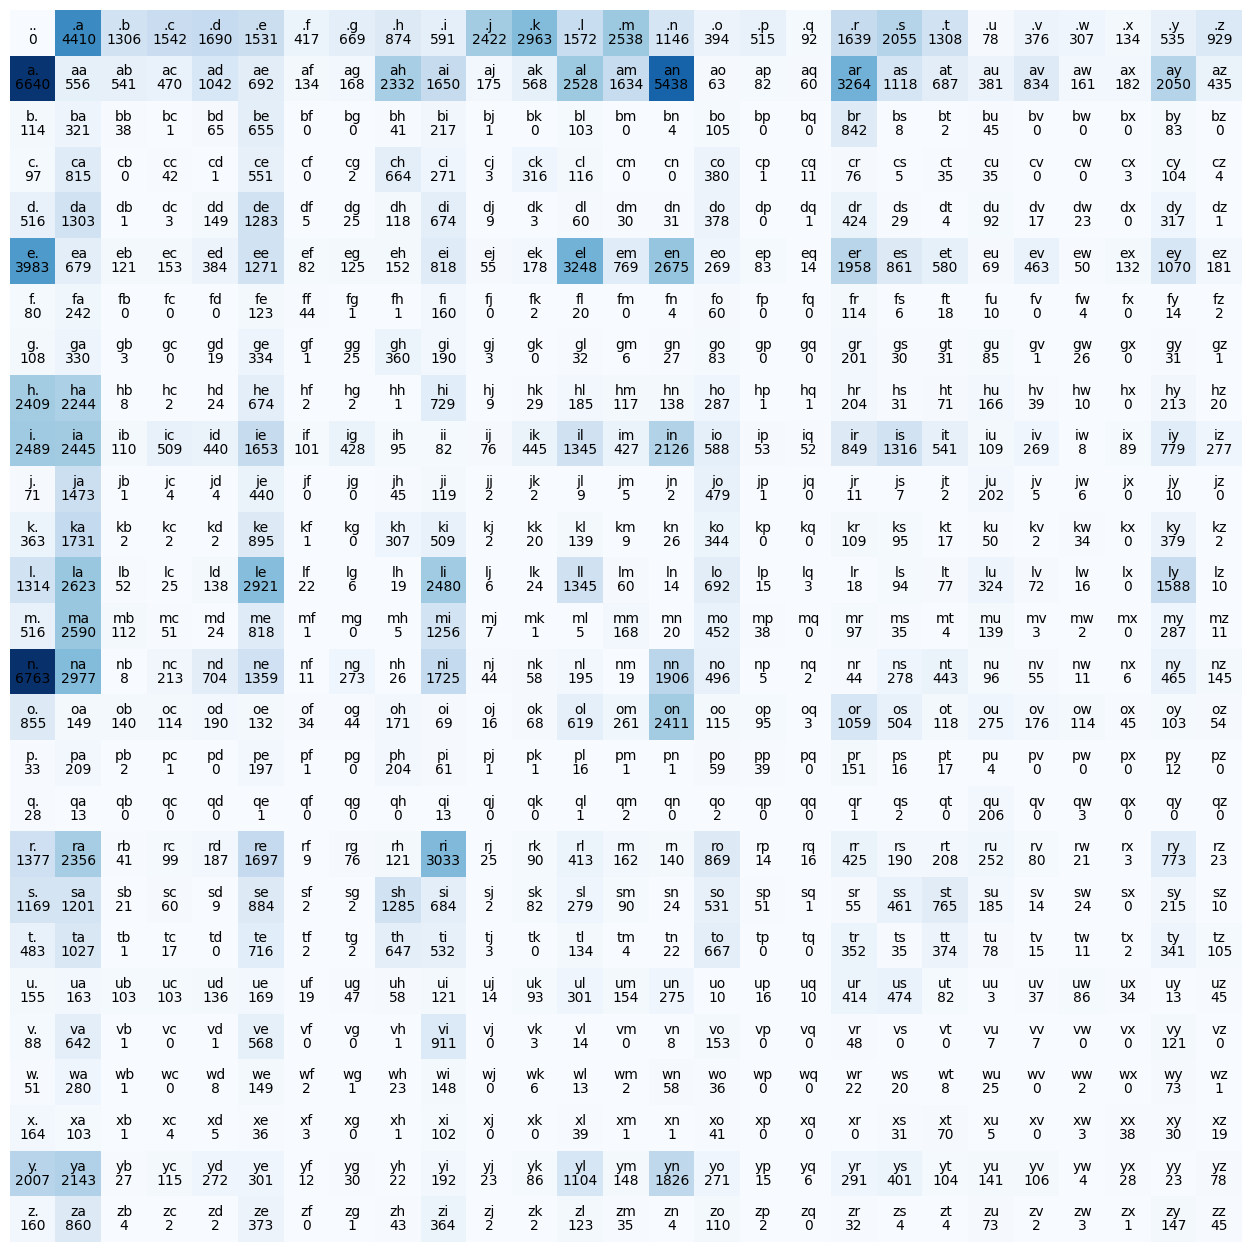

In [289]:
# Some neat visualization
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
plt.axis('off');

In [290]:
# Now to actually use this statistics, we cfirst need to create a probability vector for first character (just get first row and normalize it)
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [293]:
# And now we can just sample from it a random character (based on a probability distribution we get from the previous step)
# * Just to make it deterministic and always have the same results, we can set the seed
generator = torch.Generator().manual_seed(2147483645)
i = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
itos[i]

'm'

In [294]:
# And now we can just do it in a loop

# To be efficient let's compute probabilities for all characters in advance
# We also do N+1 which is called model "smoothing", it's just to avoid zero probabilities, because it's not good for the model to have them
P = (N+1).float() 
P /= P.sum(dim=1, keepdim=True) # N.sum(dim=1, keepdim=True) is a vector of sums of values in each row, and we can divide (27, 27) by (27, 1) because of "broadcasting rules" (internally PyTorch will just copy the vector 27 times and divide each row by the corresponding value, and that is exactly what we want for normalization)

generator = torch.Generator().manual_seed(2147483645)
for i in range(10):
    name = ''
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
        if ix == 0:
            break
        name += itos[ix]
    print(name)

machina
r
cha
n
amisilelysuronolyavydichmeye
arina
au
hari
mamiah
ecakey


In [295]:
# Some if names are good, it's better, then total random, but it's still not good enough
# First thing we need is evaluation of how good is the model, single number - the loss function
# For this we can use concept form statistics called maximum likelihood estimation, which is just the product of all probabilities on the observed (correct) set of data. The greater it is the better the model is, because it's more likely to generate the observed data. 

# We also use log, because it's easier to work with, since multiplication of small number is even smaller number, so it's easy to get underflow, logs can be added instead of multiplied, and are monotonic, so the maximum is still the same.
log_likelihood = 0.0
n = 0
for name in names:
    characters = ['.'] + list(name) + ['.']
    for chr1, chr2 in zip(characters, characters[1:]):
        i1 = stoi[chr1]
        i2 = stoi[chr2]
        prob = P[i1, i2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
# We also need to negate it, because loss function is usually minimized, but we want to maximize the likelihood
# And we also need to divide it by the number of bigrams, because we want the average log likelihood 
loss = -log_likelihood / n
loss

tensor(2.4544)

In [302]:
# Now, let's take an alternative approach and solve this problem within neural network framework
# First thing we need is training dataset
xs, ys = [], []
for name in names:
    characters = ['.'] + list(name) + ['.']
    for chr1, chr2 in zip(characters, characters[1:]):
        i1 = stoi[chr1]
        i2 = stoi[chr2]
        xs.append(i1)
        ys.append(i2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [305]:
import torch.nn.functional as F

# [Initialize network]
generator = torch.Generator().manual_seed(2147483647)
# First layer of 27 neurons connected to all inputs (27) is just a matrix of 27x27 weights
W = torch.randn((27, 27), generator=generator, requires_grad=True)
# These neurons just perform multiplication, no bias, no non-linearity (like tanh), so it's just a linear transformation

for k in range(100):
    # [Forward pass]
    # Neural networks can't work with single integer on input, so we need to convert it to one-hot encoding, which is just a vector of zeros with one 1 at the position of the integer (in our case vector is 27 long)
    xenc = F.one_hot(xs, num_classes=27).float()

    logits = xenc @ W # @ is matrix multiplication operator in PyTorch, and by doing that we actually calculated activations of all 27 neurons in the first layer simultaneously for all inputs

    # The question now is how to interpret this numbers? We cant interpret them as probabilities, because they are not normalized, and they can be negative. And we can't interpret them as counts form the previous model, because they are not integers.

    # But we can interpret them as log-counts, and then we can exponentiate them to get the counts. (exp is the inverse of log)
    counts = logits.exp() # this is ~ our N from the previous model
    # And now we can normalize them to get probabilities
    probs = counts / counts.sum(dim=1, keepdim=True)
    # Note: exponentiation and normalization together is called "softmax"

    # So far all operations were differentiable, so we can use gradient descent to optimize the weights
    pred = probs[torch.arange(num), ys] # Get the probabilities of the correct characters assigned by our model
    loss = -pred.log().mean() # And now we can calculate the negative log likelihood, our loss
    # loss += 0.1 * (W**2).sum() # This called regularization and is analog of the model smoothing from the previous model
    print(loss.item())

    # [Backward pass]
    W.grad = None # Reset the gradients
    loss.backward()
    W.data -= 50 * W.grad # Update the weights

3.758953809738159
3.371100902557373
3.154043197631836
3.020373821258545
2.927711248397827
2.8604023456573486
2.8097290992736816
2.7701022624969482
2.7380728721618652
2.711496591567993
2.6890032291412354
2.6696884632110596
2.6529300212860107
2.638277292251587
2.6253881454467773
2.613990545272827
2.60386323928833
2.5948219299316406
2.5867116451263428
2.579403877258301
2.572789192199707
2.5667762756347656
2.5612878799438477
2.5562586784362793
2.551633596420288
2.547365665435791
2.543415069580078
2.5397486686706543
2.5363364219665527
2.533154249191284
2.5301806926727295
2.5273966789245605
2.5247862339019775
2.522334575653076
2.520029067993164
2.517857789993286
2.515810489654541
2.513878345489502
2.512052059173584
2.510324001312256
2.5086867809295654
2.5071346759796143
2.5056614875793457
2.504261016845703
2.5029289722442627
2.5016605854034424
2.5004522800445557
2.4992990493774414
2.498197317123413
2.4971446990966797
2.4961376190185547
2.495173692703247
2.4942493438720703
2.493363380432129
2

In [306]:
# Sampling
generator = torch.Generator().manual_seed(2147483647)

for i in range(10):
    name = ''
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
        if ix == 0 and len(name) > 0:
            break
        name += itos[ix]
    print(name)

cexze
momasurailezityha
konimittain
llayn
ka
da
staiyauelalerigotai
moliellavo
ke
teda
